Graph Coloring Result:
Node 1: Color 0
Node 2: Color 8
Node 3: Color 21
Node 4: Color 23
Node 5: Color 22
Node 6: Color 5
Node 7: Color 11
Node 8: Color 15
Node 9: Color 26
Node 10: Color 26
Node 11: Color 18
Node 12: Color 2
Node 13: Color 5
Node 14: Color 3
Node 15: Color 20
Node 16: Color 2
Node 17: Color 6
Node 18: Color 2
Node 19: Color 6
Node 20: Color 18
Node 21: Color 13
Node 22: Color 0
Node 23: Color 4
Node 24: Color 27
Node 25: Color 5
Node 26: Color 18
Node 27: Color 13
Node 28: Color 24
Node 29: Color 2
Node 30: Color 4
Node 31: Color 17
Node 32: Color 1
Node 33: Color 4
Node 34: Color 1
Node 35: Color 19
Node 36: Color 4
Node 37: Color 18
Node 38: Color 2
Node 39: Color 14
Node 40: Color 14
Node 41: Color 25
Node 42: Color 5
Node 43: Color 3
Node 44: Color 0
Node 45: Color 26
Node 46: Color 18
Node 47: Color 16
Node 48: Color 13
Node 49: Color 23
Node 50: Color 1
Node 51: Color 9
Node 52: Color 20
Node 53: Color 12
Node 54: Color 4
Node 55: Color 23
Node 56: Color 15
Node

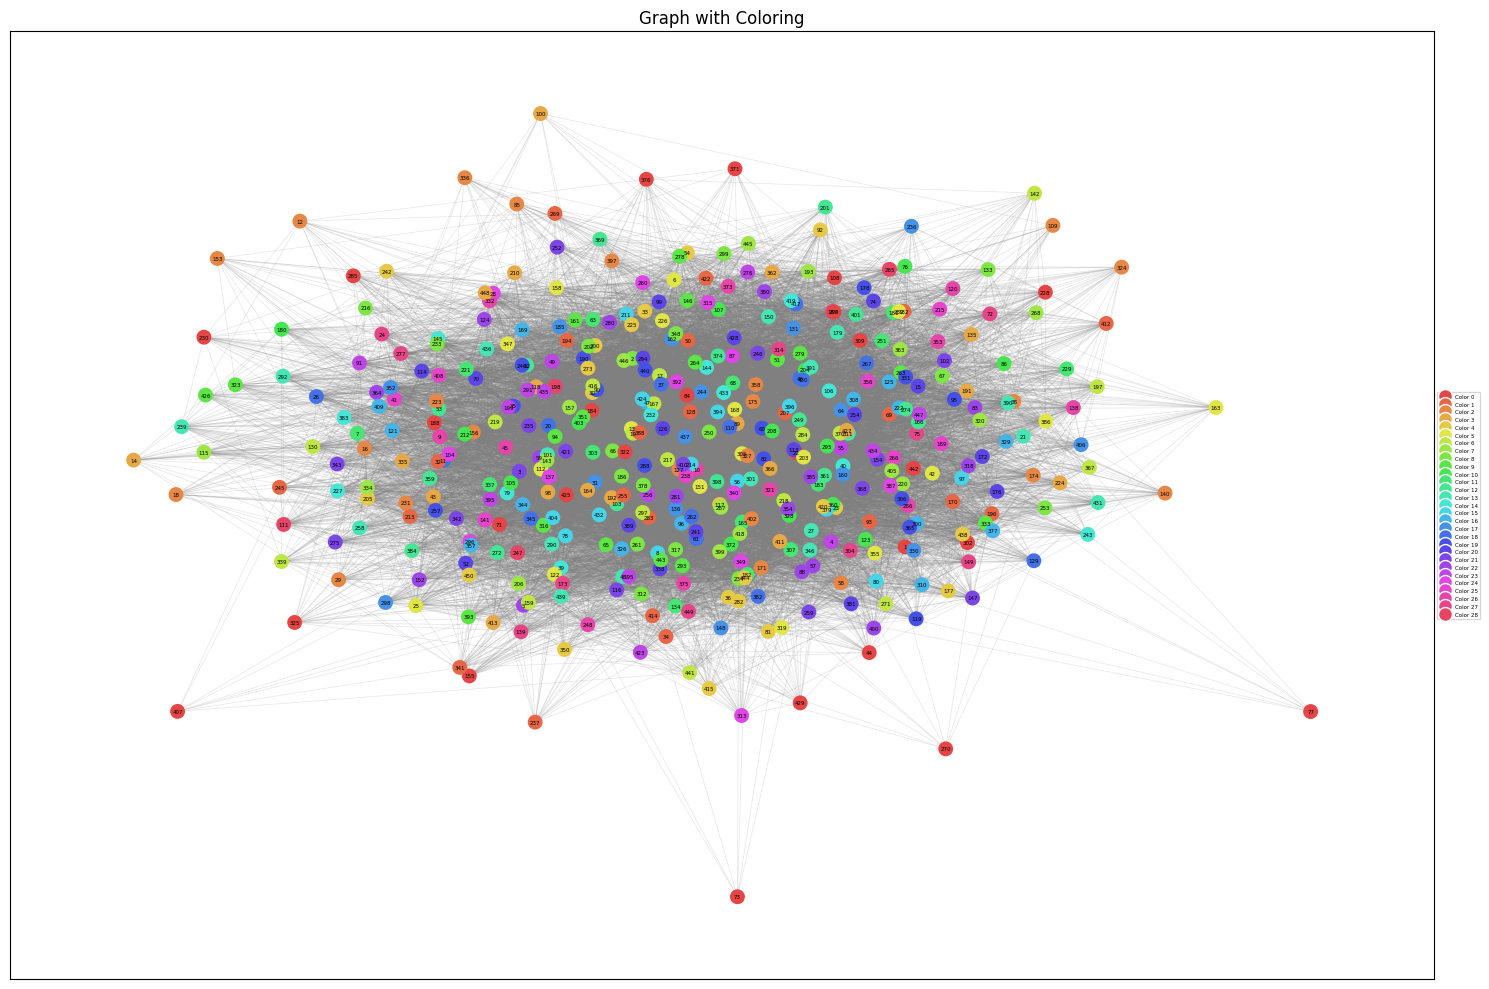


Coloring Stats:
Total colors used: 29

ℹ️ Coloring details omitted due to large number of nodes


In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import colorsys

def get_graph_from_file():
    """
    Asks the user for a file, extracts the graph, and returns an adjacency matrix.
    """
    file_name = "file.col"

    try:
        with open(file_name, "r") as file:
            lines = file.readlines()

        num_vertices = 0
        adj_matrix = None
        problem_set = False  # Ensures we process the problem line before edges

        for line in lines:
            parts = line.strip().split()

            if not parts or parts[0] == "c":
                continue

            if parts[0] == "p" and parts[1] == "edge":
                num_vertices = int(parts[2])
                adj_matrix = np.zeros((num_vertices, num_vertices), dtype=int)
                problem_set = True

            elif parts[0] == "e":
                if not problem_set:
                    raise RuntimeError("Error: Edge descriptor found before problem line")
                v1, v2 = int(parts[1]) - 1, int(parts[2]) - 1
                adj_matrix[v1][v2] = 1
                adj_matrix[v2][v1] = 1

        return adj_matrix

    except FileNotFoundError:
        print("Error: File not found!")
        return None
    except RuntimeError as e:
        print(e)
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

def sat_degree(adj_matrix, current_solution, node):
    neighbors = np.where(adj_matrix[node] == 1)[0]
    neighbor_colors = current_solution[neighbors]
    unique_colors = np.unique(neighbor_colors[neighbor_colors != -1])
    return len(unique_colors)

def dsatur(adj_matrix):
    num_vertices = len(adj_matrix)
    colors = -1 * np.ones(num_vertices, dtype=int)
    degrees = np.sum(adj_matrix, axis=1)
    uncolored = set(range(num_vertices))

    current_node = np.argmax(degrees)
    colors[current_node] = 0
    uncolored.remove(current_node)

    while uncolored:
        dsat_values = {node: sat_degree(adj_matrix, colors, node) for node in uncolored}
        current_node = max(dsat_values, key=lambda x: (dsat_values[x], degrees[x]))
        neighbor_colors = colors[np.where(adj_matrix[current_node] == 1)[0]]
        used_colors = set(neighbor_colors[neighbor_colors != -1])

        for color in range(num_vertices):
            if color not in used_colors:
                colors[current_node] = color
                break

        uncolored.remove(current_node)

    return colors

def generate_distinct_colors(n):
    colors = []
    for i in range(n):
        h = i / n
        s = 0.7
        v = 0.9
        rgb = colorsys.hsv_to_rgb(h, s, v)
        colors.append(rgb)
    return colors

def represent_graph(adj_matrix, colors=None):
    plt.close('all')
    num_nodes = adj_matrix.shape[0]
    num_edges = np.sum(adj_matrix) // 2
    print(f"\nGraph Stats:\nNodes: {num_nodes}\nEdges: {num_edges}\n")

    G = nx.Graph()
    G.add_nodes_from(range(1, num_nodes + 1))
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_matrix[i][j] == 1:
                G.add_edge(i + 1, j + 1)

    if colors is not None:
        num_colors_needed = max(colors) + 1
        color_palette = generate_distinct_colors(num_colors_needed)
        node_colors = [color_palette[c] for c in colors]
        title = "Graph with Coloring"
        print(f"\nUsing {num_colors_needed} distinct colors")
    else:
        node_colors = ['lightblue' for _ in range(num_nodes)]
        title = "Initial Graph"

    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=1/np.sqrt(num_nodes), iterations=50)
    node_size = max(50, 2000 / np.sqrt(num_nodes))
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.2, width=0.5)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors)
    font_size = max(4, 16 / np.sqrt(np.sqrt(num_nodes)))
    nx.draw_networkx_labels(G, pos, font_size=font_size)
    plt.title(title)

    if colors is not None:
        unique_colors = sorted(set(colors))
        if len(unique_colors) <= 30:
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=color_palette[c],
                             label=f'Color {c}', markersize=10)
                             for c in unique_colors]
            plt.legend(handles=legend_elements, loc='center left',
                      bbox_to_anchor=(1, 0.5), fontsize=font_size)
        else:
            print(f"\nℹ️ Legend omitted due to too many colors ({len(unique_colors)})")

    plt.tight_layout()
    plt.show()

    if colors is not None:
        print("\nColoring Stats:")
        print(f"Total colors used: {len(set(colors))}")
        if num_nodes <= 50:
            for node, color in enumerate(colors):
                print(f"Node {node + 1}: Color {color}")
        else:
            print("\nℹ️ Coloring details omitted due to large number of nodes")

def main():
    adj_matrix = get_graph_from_file()
    if adj_matrix is None:
        return

    colors = dsatur(adj_matrix)
    print("Graph Coloring Result:")
    for node, color in enumerate(colors):
        print(f"Node {node + 1}: Color {color}")

    represent_graph(adj_matrix, colors)

if __name__ == "__main__":
    main()
